tensor(0.6891, grad_fn=<MseLossBackward0>)
seq length=2 hidden_units=25 nr_episodes=0 -3.6156010190748846
seq length=2 hidden_units=25 nr_episodes=300 0.7874969729144478
seq length=2 hidden_units=25 nr_episodes=600 0.6421783106734088
seq length=2 hidden_units=25 nr_episodes=900 0.692153902645414
seq length=2 hidden_units=25 nr_episodes=1200 0.3183235498777084
seq length=2 hidden_units=25 nr_episodes=1500 0.5544544505052424
seq length=2 hidden_units=25 nr_episodes=1800 0.3334704588545633
seq length=2 hidden_units=25 nr_episodes=2100 0.6311022945030168
seq length=2 hidden_units=25 nr_episodes=2400 0.22006139135988234
seq length=2 hidden_units=25 nr_episodes=2700 0.6358334544844964
seq length=2 hidden_units=25 nr_episodes=3000 0.6314970848583658
seq length=2 hidden_units=50 nr_episodes=0 -27.02295092686701
seq length=2 hidden_units=50 nr_episodes=300 0.6978595838693521
seq length=2 hidden_units=50 nr_episodes=600 0.6712601321975642
seq length=2 hidden_units=50 nr_episodes=900 0.5379096605

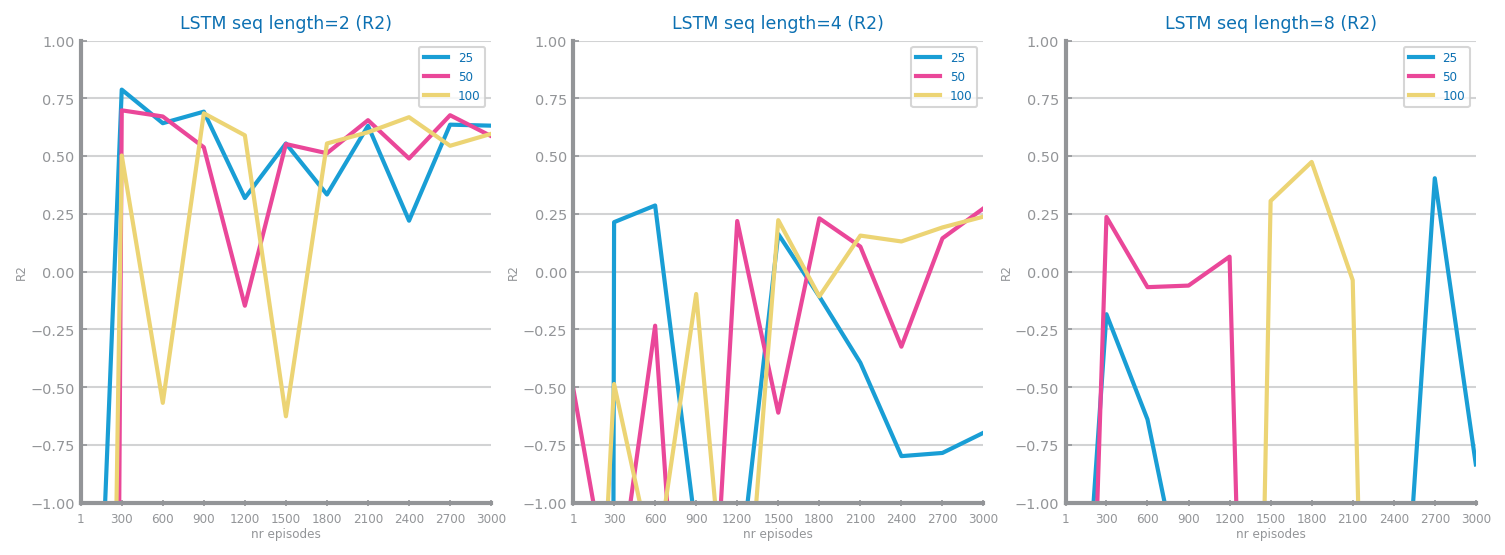

In [1]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]






from pandas import read_csv, DataFrame, Series
from dslabs_functions import series_train_test_split

filename: str = "data/time_series/forecast_covid_single.csv"
file_tag: str = "Covid-19"
target: str = "deaths"
timecol: str = "date"

measure: str = "R2"

df: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)

from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

df = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
df = df.rolling(window = 25).mean()
df.dropna(inplace=True)
df = df.diff()
df = df.diff()
df.dropna(inplace=True)
df: DataFrame = scale_all_dataframe(df)


series = df[[target]].values.astype("float32")

train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]


model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)


from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

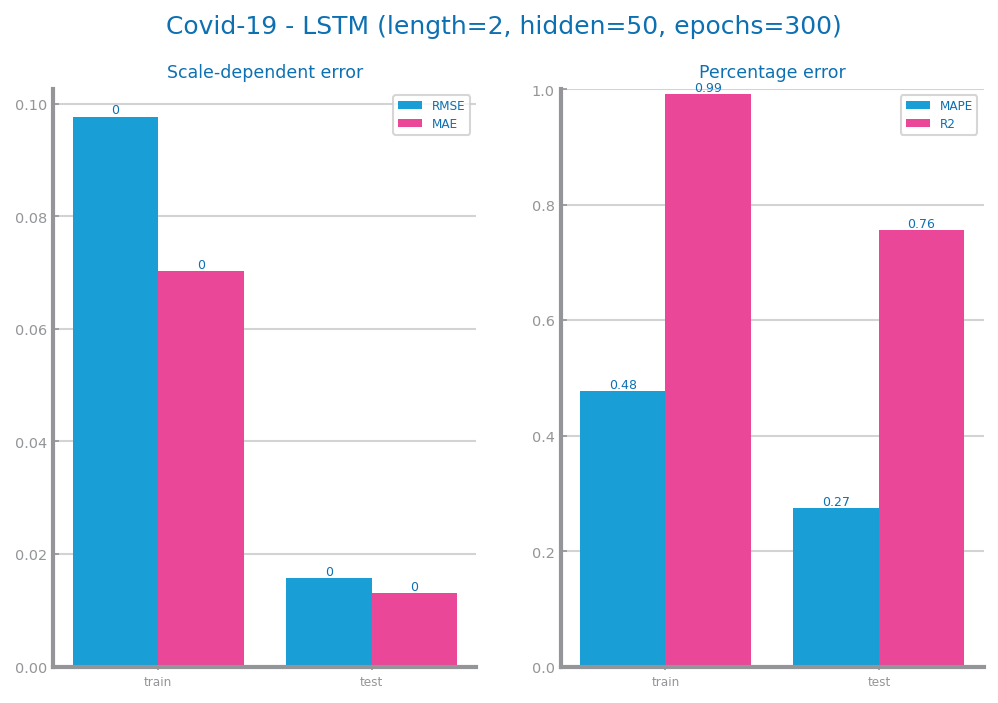

In [24]:
from matplotlib.axes import Axes
from dslabs_functions import plot_multibar_chart


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    # fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig, axs = subplots(1, 2, figsize=(8, 5), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs

params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}_lstms_{measure}_eval.png")

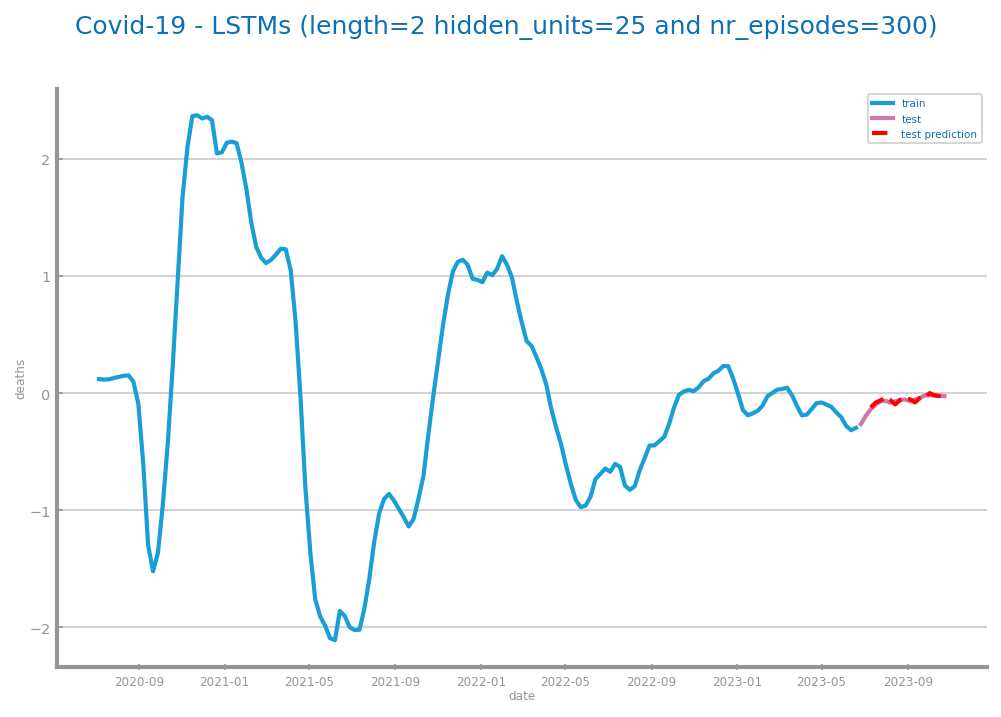

In [32]:
from config import FUTURE_COLOR, PAST_COLOR, PRED_FUTURE_COLOR


def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    # fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig, ax = subplots(1, 1, figsize=(8, 5), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

series = df[[target]]
train_temp, test_temp = series[:train_size], series[train_size:]

pred_series: Series = Series(prd_tst.numpy().ravel(), index=test_temp.index[best_length:])

plot_forecasting_series(
    train_temp,
    test_temp,
    pred_series,
    title=f"{file_tag} - LSTMs (length=2 hidden_units=25 and nr_episodes=300)",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_lstms_{measure}_forecast.png")